#Upstart Data Challenge
##Helen Craig
##January 20, 2016
<a href='UpstartDSProject.pdf'>Original Doc</a>

<a href='loan_data.csv'>In the CSV file that accompanies this document</a> are a set of loans issued between
October 2014 and September 2015. The performance of these loans has been
observed through October 2015.

As of October 2015, each loan was marked (in the column loan status) as “Current”,
“Fully Paid”, or “Charged Off”. “Current” means that the borrower is either
on or ahead of schedule in terms of paying off his or her loan. “Fully Paid” means
that the loan has been entirely paid off. “Charged Off” means that the borrower
has stopped paying and defaulted on the loan.

In addition to loan status, other variables included in the dataset are a unique
member id, loan amount, interest rate, the date the loan was issued, lower and
upper endpoints of the range of the borrower’s FICO score, annual income, and the
date of the last payment that was made by the borrower.

Please answer the following questions. Along with your answers, feel free to send
over any code you used to obtain them. (Showing your work can get you partial
credit!)

1. What is the relationship between FICO score and interest rate?
2. What is the relationship between loan size and interest rate?
3. Does it seem like the size of a loan and/or the borrower’s FICO score are
related to whether or not the loan ends up being charged off? How might
this relate to your answer to the previous question?
4. What percentage of loans have been charged off as of October 2015?
5. Some of the loans which are marked “Current” in October 2015 will end
up being charged off before they are paid in full. Using the fact that all of
these loans are 3 years in length, estimate the probability that a randomly
chosen loan would eventually become charged off, possibly after October
2015. Be sure to explain any assumptions you make.

P.S. We want you to spend a few hours on this not a few days! (But feel free to
comment on any other interesting patterns or relationships in the data.)

##Preliminary Work
###Load libraries

In [1]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
import numpy
import scipy
from scipy.optimize import curve_fit

###Load data

In [2]:
data=pandas.read_csv('loan_data.csv',encoding='ISO-8859-1',header=0)

###Column heads

In [3]:
data.columns.values

array([u'member_id', u'loan_amnt', u'int_rate', u'issue_d', u'loan_status',
       u'fico_range_low', u'fico_range_high', u'annual_inc',
       u'last_pymnt_d'], dtype=object)

###Each user is unique

In [4]:
print '# of unique member_id',len(data['member_id'].unique()),'   # of loans',len(data)

# of unique member_id 239046    # of loans 239046


###Three possibilities for loan status

In [5]:
print data['loan_status'].unique()

[u'Fully Paid' u'Current' u'Charged Off']


###The low and high fico scores are related
In future work, I will only work with the low range of the fico score

In [6]:
data['fico_range_low'].unique()

array([700, 670, 665, 730, 680, 725, 675, 745, 715, 660, 735, 695, 775,
       720, 705, 790, 690, 770, 685, 710, 800, 840, 780, 740, 805, 760,
       825, 815, 750, 765, 810, 755, 785, 795, 820, 835, 830, 845])

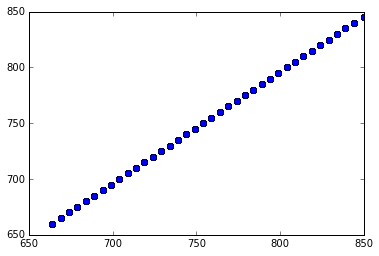

In [7]:
plt.plot(data['fico_range_high'],data['fico_range_low'],'o',alpha=0.5)

###Adding Columns
I will convert the issue date column and the last payment date column into numerical values from 0 to 12 to make calculations easier.  I also calculate the value between the last payment and the issue date.  I calculate the numerical value for the interests rate.

In [8]:
date={'Oct 2014':0,
     'Nov 2014':1,
     'Dec 2014':2,
     'Jan 2015':3,
     'Feb 2015':4,
     'Mar 2015':5,
     'Apr 2015':6,
     'May 2015':7,
     'Jun 2015':8,
     'Jul 2015':9,
     'Aug 2015':10,
     'Sep 2015':11,
     'Oct 2015':12}
data['date_diff'] = pandas.Series([0 if i!=i else date[i]-date[j] for i,j in zip(data['last_pymnt_d'],data['issue_d'])], index=data.index)
data['issue_d_numeric'] = pandas.Series([date[j] for j in data['issue_d']], index=data.index)
data['last_pymnt_d_numeric'] = pandas.Series([-1 if j!=j else date[j] for j in data['last_pymnt_d']], index=data.index)
data['int_rate_numeric'] = pandas.Series([float(i[:-1])/100.0 for i in data['int_rate']], index=data.index)


#1. What is the relationship between FICO score and interest rate?

###Plot of FICO score vs. Interest Rate
The below plot is FICO score versus interest rate.  The interest rate generally dicreases with an increase in FICO score.  Also note the systematically large error bars.  This indicates other underlying variables contributing to the calculation of the interest rate.

/usr/local/Cellar/python/2.7.8_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


<Container object of 3 artists>

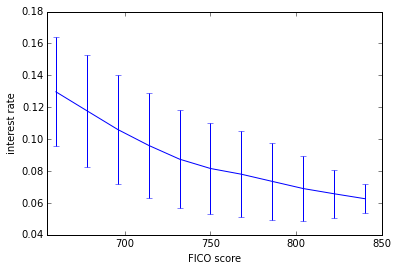

In [9]:
deltaScore=(max(data['fico_range_low'])-min(data['fico_range_low']))/10
scoreArray=range(min(data['fico_range_low']),max(data['fico_range_low']),deltaScore)

avgRate=[numpy.mean(data[
            data['fico_range_low']>=scoreIndex][
            data['fico_range_low']<scoreIndex+deltaScore]['int_rate_numeric'].values)
        for scoreIndex in scoreArray]
stdRate=[numpy.std(data[
            data['fico_range_low']>=scoreIndex][
            data['fico_range_low']<scoreIndex+deltaScore]['int_rate_numeric'].values)
        for scoreIndex in scoreArray]
plt.xlim([min(data['fico_range_low'])-5,max(data['fico_range_low'])+5])
plt.xlabel('FICO score')
plt.ylabel('interest rate')
plt.errorbar(scoreArray, avgRate, yerr=stdRate)

#2. What is the relationship between loan size and interest rate?

###Plot of Loan Size vs. Interest Rate
Below is a plot of loan size versus interest rate.  The loan amount does not seem to be strongly correlated to the interest rate.  There is a slight decrease with loan amount but not too strong and the data at high loan amounts does not follow this trend.

<Container object of 3 artists>

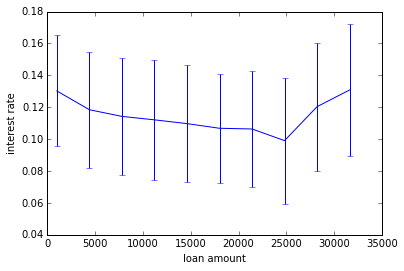

In [10]:
deltaAmount=(max(data['loan_amnt'])-min(data['loan_amnt']))/10.0
amountArray=numpy.arange(min(data['loan_amnt']),max(data['loan_amnt']),deltaAmount)

avgRate=[numpy.mean(data[
            data['loan_amnt']>=amountIndex][
            data['loan_amnt']<amountIndex+deltaAmount]['int_rate_numeric'].values)
        for amountIndex in amountArray]
stdRate=[numpy.std(data[
            data['loan_amnt']>=amountIndex][
            data['loan_amnt']<amountIndex+deltaAmount]['int_rate_numeric'].values)
        for amountIndex in amountArray]
plt.xlabel('loan amount')
plt.ylabel('interest rate')
plt.errorbar(amountArray, avgRate, yerr=stdRate)

#3. Does it seem like the size of a loan and/or the borrower’s FICO score are related to whether or not the loan ends up being charged off? How might this relate to your answer to the previous question?

###Charge Off Percentage Calculation
The calculation of the percentage of charge off is tricky since it changes with time.  Loans that are closer to the issue date will not be charged off as often and also, loans are typically not charged off until the member has not given a payment in 6 months.  So there are a lot of loans that we would not expect to be charged off yet but may be in the future.

What I can do to increase the signal of the charged off loans is to look only at the loans issued in the first two months and only the charged off loans that had there last payment in the first 6 months of data.

###FICO score vs. Charged Off Percentage
Below are graphs of FICO score versus percentage of loans charged off.  The two different lines are the first and second months of data.  There is a clear decrease in the percentage with increase in FICO score for low FICO score.  At high FICO score, the data is more sparse so the percentage is much more noisy.  

In [11]:
deltaScore=(max(data['fico_range_low'])-min(data['fico_range_low']))/30
scoreArray=range(min(data['fico_range_low']),max(data['fico_range_low']),deltaScore)

def plotscoreVsChargedOff():
    for issueDate in range(2):
        scoreVsChargedOff=[float(len(data[
            data['fico_range_low']>=scoreIndex][
            data['fico_range_low']<scoreIndex+deltaScore][data['issue_d_numeric']==issueDate][
                data['last_pymnt_d_numeric']<7][
            data['loan_status']=='Charged Off'].values))/float(len(data[
            data['fico_range_low']>=scoreIndex][
            data['fico_range_low']<scoreIndex+deltaScore][data['issue_d_numeric']==issueDate]))
        for scoreIndex in scoreArray]
    
        plt.plot(scoreArray, scoreVsChargedOff)
    plt.xlabel('FICO score')
    plt.ylabel('charged off percentage')
    plt.show()

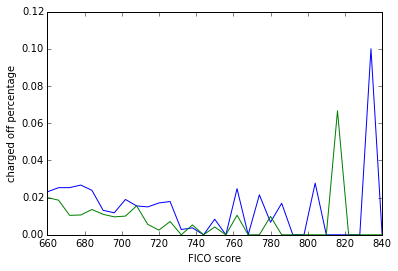

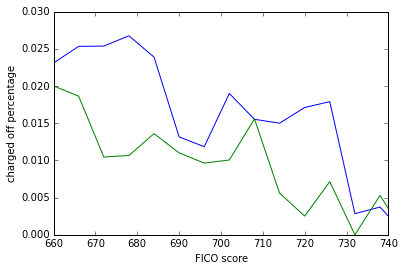

In [12]:
plotscoreVsChargedOff()
plt.xlim([660,740])
plt.ylim([0,.03])
plotscoreVsChargedOff()

###Loan Amount vs. Charged Off Percentage
Below are graphs of loan amount versus percentage of loans charged off.  The two different lines are the first and second months of data.  There is a slight decrease in the percentage for larger loan amounts but again the data is noisy at large loan amount because of the sparse data.  

[13, 18, 26, 44, 54, 43, 39, 74, 18, 22, 10, 14, 27, 12, 6, 4, 21, 6, 1, 0, 10, 10, 2, 6, 0, 6, 3, 1, 2, 1, 11]
[5, 11, 8, 32, 19, 7, 11, 21, 4, 12, 5, 9, 7, 7, 1, 5, 7, 0, 1, 0, 1, 4, 2, 2, 1, 6, 1, 0, 1, 0, 11]


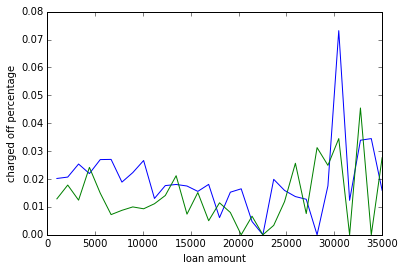

In [13]:
deltaAmount=(max(data['loan_amnt'])-min(data['loan_amnt']))/30.0
amountArray=numpy.arange(min(data['loan_amnt']),max(data['loan_amnt']),deltaAmount)

for issueDate in range(2):
    amountVsChargedOff=[float(len(data[
            data['loan_amnt']>=amountIndex][
            data['loan_amnt']<amountIndex+deltaAmount][data['issue_d_numeric']==issueDate][
                data['last_pymnt_d_numeric']<7][
            data['loan_status']=='Charged Off'].values))/float(len(data[
            data['loan_amnt']>=amountIndex][
            data['loan_amnt']<amountIndex+deltaAmount][data['issue_d_numeric']==issueDate]))
        for amountIndex in amountArray]
    print [len(data[
            data['loan_amnt']>=amountIndex][
            data['loan_amnt']<amountIndex+deltaAmount][data['issue_d_numeric']==issueDate][
                data['last_pymnt_d_numeric']<7][
            data['loan_status']=='Charged Off'].values) for amountIndex in amountArray]

    plt.plot(amountArray, amountVsChargedOff)
plt.xlabel('loan amount')
plt.ylabel('charged off percentage')
plt.show()

###Charged off rate and interest rate
Larger interest rates correspond to lower FICO scores and (slightly) higher loan amounts.  Also larger charged off rate correspond to lower FICO scores and (slightly) lower loan amounts.  This makes sense since the loans that are more likely to not get paid off have a higher interest rate so that the loaner can make a profit on average.


 #4. What percentage of loans have been charged off as of October 2015?
 
 0.7% have been charged off over the previous year of data:

In [14]:
float(len(data[data['loan_status']=='Charged Off']))/float(len(data))

0.007040485931578023

#5. Some of the loans which are marked “Current” in October 2015 will end up being charged off before they are paid in full. Using the fact that all of these loans are 3 years in length, estimate the probability that a randomly chosen loan would eventually become charged off, possibly after October 2015. Be sure to explain any assumptions you make.

There are a number of difficulties in making this calculation.  First, we do not have 3 years of data.  This is a problem because the older the loan is, the more likely it will be charged off but we only have a years worth of data so it is unclear whether this pattern continues or if it changes from year to year.  

###Homogeneous assumption
One assumption that I will make is that the distribution of loan amounts, FICO scores, interests rates, and annual incomes of members is the same from month to month.  Below are graphs that show this to be approximately correct. 

###Loan amount

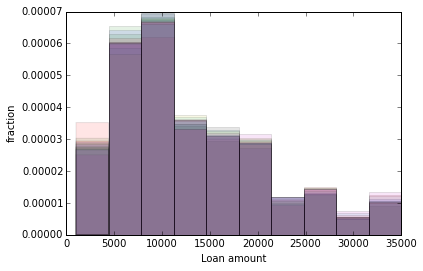

In [15]:
for dateIndex in range(len(date)-1):
    plt.hist(data[data['issue_d_numeric']==dateIndex]['loan_amnt'].values,alpha=.1,normed=1)
    plt.xlabel('Loan amount')
    plt.ylabel('fraction')

###Fico Score

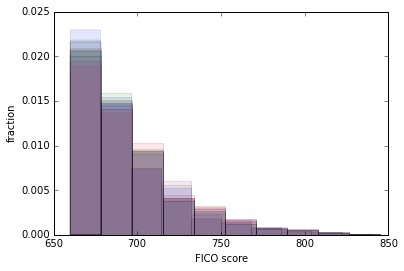

In [16]:
for dateIndex in range(len(date)-1):
    plt.hist(data[data['issue_d_numeric']==dateIndex]['fico_range_low'].values,alpha=.1,normed=1)
    plt.xlabel('FICO score')
    plt.ylabel('fraction')

###Interest rate

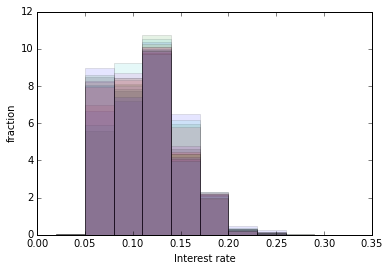

In [17]:
bins=numpy.arange(.02,.35,.03)
for dateIndex in range(len(date)-1):
    plt.hist(data[data['issue_d_numeric']==dateIndex]['int_rate_numeric'].values,bins=bins,alpha=.1,normed=1)
    plt.xlabel('Interest rate')
    plt.ylabel('fraction')

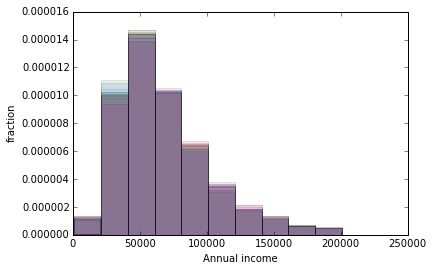

In [18]:
bins=[1000,21000,41000,61000,81000,101000,121000,141000,161000,181000,201000,]
for dateIndex in range(len(date)-1):
    plt.hist(data[data['issue_d_numeric']==dateIndex]['annual_inc'].values,bins=bins,alpha=.1,normed=1)
    plt.xlabel('Annual income')
    plt.ylabel('fraction')

###Fully paid percentage vs. Time

Below is a plot of the percentage of fully paid loan as a function of how old the loan is.  The different colors are the different issuing months.  Not all months have all data for all of the ages because the data only goes up to a certain time.

There is a clear increasing rate of people paying off the debt as the loan ages.

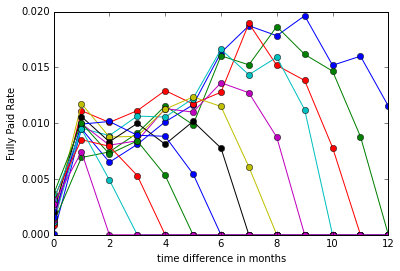

In [19]:
for index in range(len(date))[0:12]:
    tot=len(data[data['issue_d_numeric']==index])
    if tot==0:
        tot=1
    y=[float(len(data[data['issue_d_numeric']==index][data['loan_status']=='Fully Paid'][data['date_diff']==i]))/float(tot) for i in range(len(date))]
    plt.plot(range(len(date)),y,'-o')
plt.xlabel('time difference in months')
plt.ylabel('Fully Paid Rate')
plt.show()

###Charged off rate vs. Time

Similarly, there is an increase in charged off rate as a loan ages.  Note that charged off status is usually assigned after 6 months of non-payment so only those loans that have their last payment at least 6 months in the past do we have the full charge off rate.  

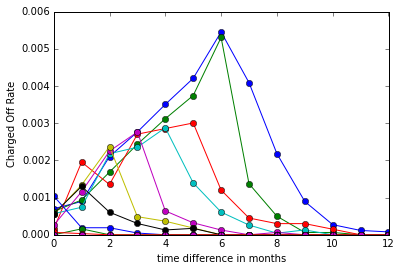

In [20]:
for index in range(len(date))[0:12]:
    tot=len(data[data['issue_d_numeric']==index])
    if tot==0:
        tot=1
    y=[float(len(data[data['issue_d_numeric']==index][data['loan_status']=='Charged Off'][data['date_diff']==i]))/float(tot) for i in range(len(date))]
    plt.plot(range(len(date)),y,'-o')
plt.xlabel('time difference in months')
plt.ylabel('Charged Off Rate')
plt.show()

###Simple linear models
If I assume that the charge off rate and the paid off rate increase linear with time, I can calculate the time when the loans are either all paid off or all charged off.  Below I calculate constants of such a model.

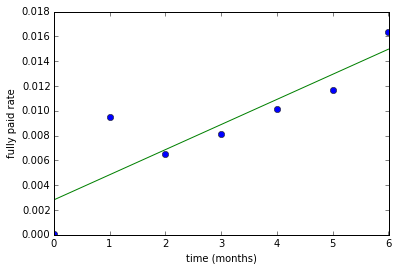

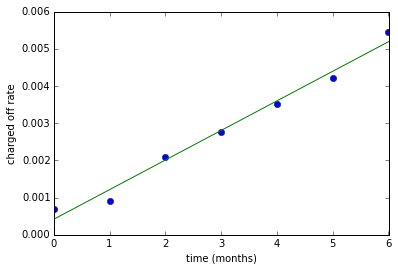

In [21]:
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

tot=len(data[data['issue_d_numeric']==0])
x=range(7)

y=[float(len(data[data['issue_d_numeric']==0][data['loan_status']=='Fully Paid'][data['date_diff']==i]))/float(tot) for i in range(7)]
Afp,Bfp = curve_fit(f, x, y)[0] # your data x, y to fit
plt.xlabel('time (months)')
plt.ylabel('fully paid rate')
plt.plot(x,y,'o')
plt.plot(x,[f(i,Afp,Bfp) for i in x])
plt.show()

y=[float(len(data[data['issue_d_numeric']==0][data['loan_status']=='Charged Off'][data['date_diff']==i]))/float(tot) for i in range(7)]
Aco,Bco = curve_fit(f, x, y)[0] # your data x, y to fit
plt.xlabel('time (months)')
plt.ylabel('charged off rate')
plt.plot(x,y,'o')
plt.plot(x,[f(i,Aco,Bco) for i in x])
plt.show()

###Results of linear model
Below is a calculation of the cumulative percentages of charge off and fully paid loans.  After 25 months, 27% of the loans will be charged off and 73% will be fully paid.

In [22]:
cumChargeOff=0
cumFullyPaid=0
for i in range(36):
    cumChargeOff+=f(i,Aco,Bco)
    cumFullyPaid+=f(i,Afp,Bfp)
    if cumChargeOff+cumFullyPaid>1:
        print 'months:',i,'  charged off:',cumChargeOff,'   fully paid',cumFullyPaid
        break;

months: 25   charged off: 0.269439421364    fully paid 0.731772151135
